# Spatial Models - Networks

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from scipy import stats

%matplotlib inline
plt.style.use('default')

In [2]:
# Import the csv file
df = pd.read_csv('transmission_network.csv', sep=';')
df = df.rename(columns={df.columns[0]:'nodes'})

In [3]:
# Create graph object and add nodes to it
Graph_obj = nx.Graph()
nodes = df['nodes'].tolist()
Graph_obj.add_nodes_from(nodes)

In [4]:
# Add edges between nodes based on the csv-file
for _, row in df.iterrows():
    source_node = row['nodes']
    for col_name, edge_value in row.items():
        if col_name != 'nodes' and edge_value != 0:
            Graph_obj.add_edge(source_node, int(col_name))

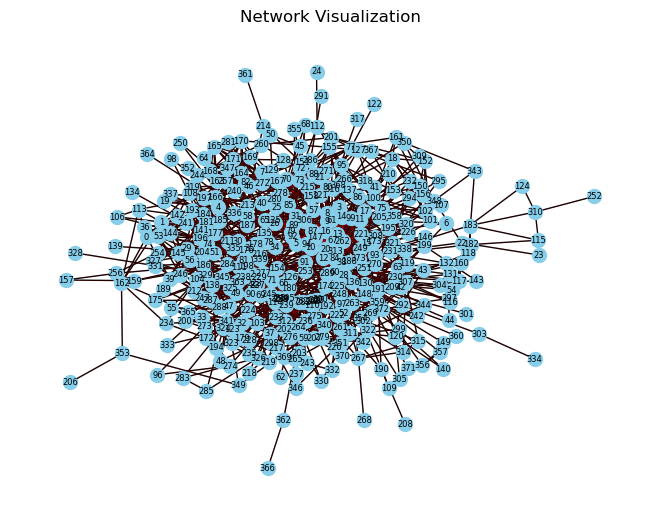

In [5]:
# Relabel the nodes
Graph_obj = nx.convert_node_labels_to_integers(Graph_obj, first_label=0)

# create a layout for the nodes
pos = nx.kamada_kawai_layout(Graph_obj)

# draw the nodes and edges
nx.draw(Graph_obj, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=6, font_color='black')
nx.draw_networkx_edges(Graph_obj, pos, edge_color='red', width=0.1)

# display the graph
plt.axis('off')
plt.title("Network Visualization")
plt.show()

In [6]:
# Generate SIR model object
SIR_model = ep.SIRModel(Graph_obj)

# Set parameter values
betas = np.linspace(0.1, 3, 101)
gammas = np.linspace(0.01, 1, 101)
percentage_infected = 0.01
nr_iterations = 200

# Pre-allocate variables.
S_store = np.zeros((len(betas), len(gammas), nr_iterations))
I_store = np.zeros((len(betas), len(gammas), nr_iterations))
R_store = np.zeros((len(betas), len(gammas), nr_iterations))

# Run experiment
cfg = mc.Configuration()
cfg.add_model_parameter("percentage_infected", percentage_infected)

for beta_ix, beta in enumerate(betas):
    for gamma_ix, gamma in enumerate(gammas):
        # (Re)set every node as susceptible
        for node in Graph_obj.nodes():
            SIR_model.status[node] = 0
            
        # Set model configurations
        cfg.add_model_parameter('beta', beta)
        cfg.add_model_parameter('gamma', gamma)
        SIR_model.set_initial_status(cfg)
        iterations = SIR_model.iteration_bunch(nr_iterations, node_status=True)
        trends = SIR_model.build_trends(iterations)
        
        # Extract values based on updated structure
        node_counts = trends[0]['trends']['node_count']
        S = node_counts[0]
        I = node_counts[1]
        R = node_counts[2]

        # Store the sums for averages
        S_store[beta_ix, gamma_ix] = S
        I_store[beta_ix, gamma_ix] = I
        R_store[beta_ix, gamma_ix] = R

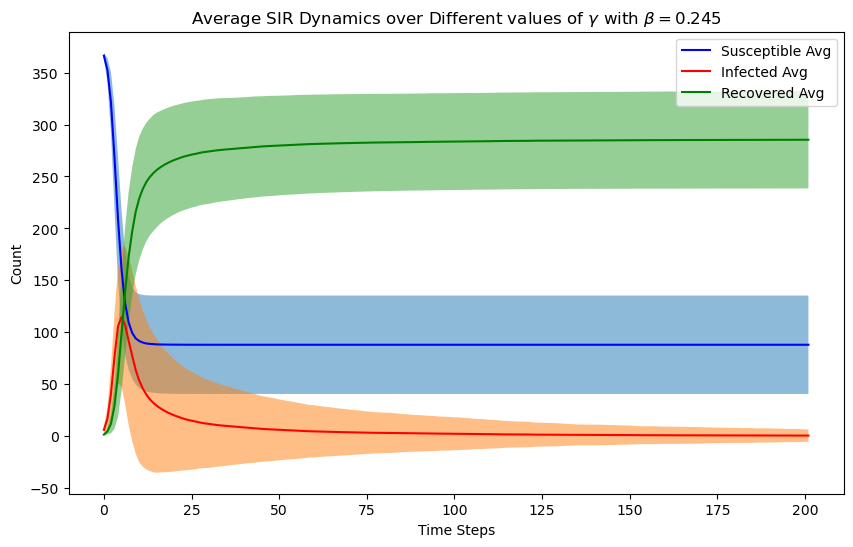

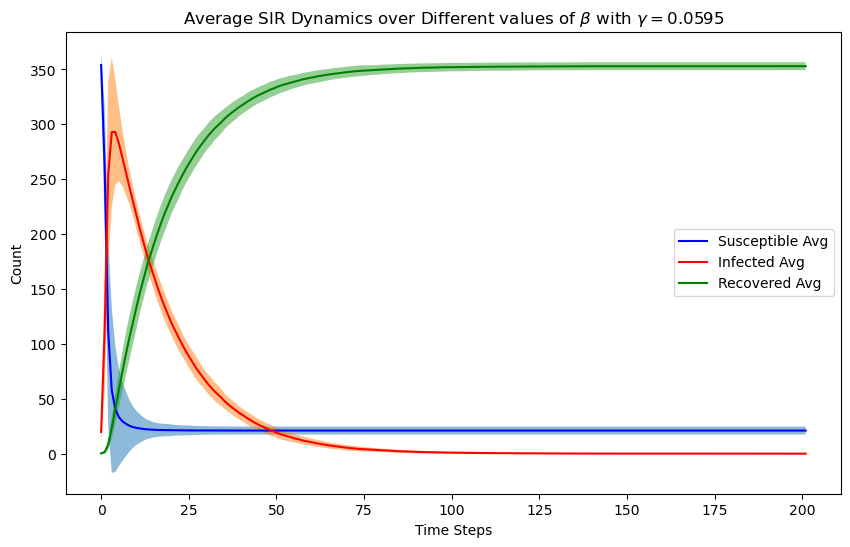

In [8]:
beta_index = 5
Gamma_index = 5

S_mean_0 = np.mean(S_store[beta_index], axis=0)
I_mean_0 = np.mean(I_store[beta_index], axis=0)
R_mean_0 = np.mean(R_store[beta_index], axis=0)
S_std_0 = np.std(S_store[beta_index], axis=0)
I_std_0 = np.std(I_store[beta_index], axis=0)
R_std_0 = np.std(R_store[beta_index], axis=0)

S_mean_1 = np.mean(S_store[:, Gamma_index], axis=0)
I_mean_1 = np.mean(I_store[:, Gamma_index], axis=0)
R_mean_1 = np.mean(R_store[:, Gamma_index], axis=0)
S_std_1 = np.std(S_store[:, Gamma_index], axis=0)
I_std_1 = np.std(I_store[:, Gamma_index], axis=0)
R_std_1 = np.std(R_store[:, Gamma_index], axis=0)

x = np.linspace(0, 201, 200)

# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(x, S_mean_0, label="Susceptible Avg", color='blue')
plt.fill_between(x, S_mean_0 - S_std_0,S_mean_0 + S_std_0, alpha=0.5) 
plt.plot(x, I_mean_0, label="Infected Avg", color='red')
plt.fill_between(x, I_mean_0 - I_std_0,I_mean_0 + I_std_0, alpha=0.5) 
plt.plot(x, R_mean_0, label="Recovered Avg", color='green')
plt.fill_between(x, R_mean_0 - R_std_0,R_mean_0 + R_std_0, alpha=0.5) 
plt.title(fr"Average SIR Dynamics over Different values of $\gamma$ with $\beta = {betas[beta_index]}$")
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.show()

# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(x, S_mean_1, label="Susceptible Avg", color='blue')
plt.fill_between(x, S_mean_1 - S_std_1,S_mean_1 + S_std_1, alpha=0.5) 
plt.plot(x, I_mean_1, label="Infected Avg", color='red')
plt.fill_between(x, I_mean_1 - I_std_1,I_mean_1 + I_std_1, alpha=0.5) 
plt.plot(x, R_mean_1, label="Recovered Avg", color='green')
plt.fill_between(x, R_mean_1 - R_std_1,R_mean_1 + R_std_1, alpha=0.5) 
plt.title(fr"Average SIR Dynamics over Different values of $\beta$ with $\gamma = {gammas[beta_index]}$")
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.show()

## Similar networks

In [9]:
def statistic_func(Graph):
    # Pre-allocating return variable
    stats = {}
    
    stats['Nr_of_nodes'] = Graph.number_of_nodes()
    stats['Nr_of_edges'] = Graph.number_of_edges()
        

    degrees = [degree for degree in Graph.degree()]
    stats['Average_degree'] = np.mean(degrees)
    
    
    if degrees:
        stats['average_clustering_coefficient'] = nx.average_clustering(Graph)
        stats['density'] = nx.density(Graph)
        
        degree_centralities = nx.degree_centrality(Graph)
        stats['average_degree_centrality'] = np.mean(list(degree_centralities.values()))
        
        betweenness_centralities = nx.betweenness_centrality(Graph)
        stats['average_betweenness_centrality'] = np.mean(list(betweenness_centralities.values()))
        
        closeness_centrality = nx.closeness_centrality(Graph)
        stats['average_closeness_centrality'] = np.mean(list(closeness_centrality.values()))
        
        if nx.is_connected(Graph):
            stats['diameter'] = nx.diameter(Graph)
            stats['average_shortest_path_length'] = nx.average_shortest_path_length(Graph)
            
        else:
            stats['diameter'] = None
            stats['average_shortest_path_length'] = None
    else:
        stats['average_clustering_coefficient'] = None
        stats['density'] = None
        stats['average_degree_centrality'] = None
        stats['average_betweenness_centrality'] = None
        stats['average_closeness_centrality'] = None

    return stats

### Erdös-Rénji Network


In [10]:
network_size = np.arange(50, 550, 50)
connection_probability = np.arange(0.05, 1.05, 0.05)

results_ER = []

for size in network_size:
    for p in connection_probability:
        Graph_ER = nx.erdos_renyi_graph(size, p)
        stats_ER = statistic_func(Graph_ER)
        results_ER.append(stats_ER)

df_ER = pd.DataFrame(results_ER)

In [11]:
custom_summary = df_ER.groupby(df_ER.columns[0]).agg(['mean', 'std', 'median', 'min', 'max','var'])
display(custom_summary)

Nr_of_edges                                                     \
                   mean           std   median   min     max           var   
Nr_of_nodes                                                                  
50               642.85    361.845311    633.5    59    1225  1.309320e+05   
100             2605.95   1459.988121   2615.5   239    4950  2.131565e+06   
150             5867.65   3306.236934   5904.5   542   11175  1.093120e+07   
200            10451.55   5898.181294  10454.0   996   19900  3.478854e+07   
250            16340.40   9191.469400  16349.0  1566   31125  8.448311e+07   
300            23555.20  13278.545111  23459.0  2235   44850  1.763198e+08   
350            32026.20  18082.277129  31957.5  3006   61075  3.269687e+08   
400            41915.55  23601.696497  42062.0  3938   79800  5.570401e+08   
450            53043.40  29884.714472  53110.5  5009  101025  8.930962e+08   
500            65430.40  36950.354974  65380.5  6223  124750  1.365329e+09   

            Average_degree                                     ... diameter  \
                      mean        std      median         min  ...   median   
Nr_of_nodes                                                    ...            
50               25.107000   7.236906   24.920000   13.430000  ...      2.0   
100              50.809500  14.599881   50.905000   27.140000  ...      2.0   
150              76.367667  22.041580   76.613333   40.863333  ...      2.0   
200             102.007750  29.490906  102.020000   54.730000  ...      2.0   
250             127.611600  36.765878  127.646000   68.514000  ...      2.0   
300             153.267333  44.261817  152.946667   82.200000  ...      2.0   
350             178.753429  51.663649  178.557143   95.838571  ...      2.0   
400             204.538875  59.004241  204.905000  109.595000  ...      2.0   
450             230.124222  66.410477  230.273333  123.381111  ...      2.0   
500             255.610800  73.900710  255.511000  137.196000  ...      2.0   

                                average_shortest_path_length            \
             min  max       var                         mean       std   
Nr_of_nodes                                                              
50           1.0  5.0  0.812865                     1.502943  0.386851   
100          1.0  7.0  1.523684                     1.550465  0.478963   
150          1.0  5.0  0.618421                     1.525530  0.411594   
200          1.0  4.0  0.378947                     1.512166  0.378301   
250          1.0  4.0  0.344737                     1.504247  0.359582   
300          1.0  4.0  0.344737                     1.499983  0.350667   
350          1.0  4.0  0.344737                     1.497325  0.342776   
400          1.0  3.0  0.200000                     1.493417  0.335492   
450          1.0  3.0  0.200000                     1.491142  0.329492   
500          1.0  3.0  0.155263                     1.489499  0.324699   

                                                
               median  min       max       var  
Nr_of_nodes                                     
50           1.458776  1.0  2.553469  0.149654  
100          1.471616  1.0  3.095354  0.229406  
150          1.471633  1.0  2.744787  0.169409  
200          1.474673  1.0  2.553920  0.143111  
250          1.474731  1.0  2.463968  0.129299  
300          1.476945  1.0  2.405641  0.122968  
350          1.476750  1.0  2.358248  0.117496  
400          1.472907  1.0  2.310238  0.112555  
450          1.474284  1.0  2.263945  0.108565  
500          1.475908  1.0  2.224184  0.105429  

[10 rows x 54 columns]

In [12]:
ps = np.arange(0.018, 0.02, 0.001)
for p in ps:
    Graph_ER = nx.erdos_renyi_graph(374, p)
    stats_ER = statistic_func(Graph_ER)
    print(p, stats_ER['Nr_of_edges'])

0.018 1207
0.019 1332
0.02 1411


In [13]:
# Generate Barabasi-Albert graph similar to the given model
Graph_ER = nx.erdos_renyi_graph(374, 0.019)

# Generate SIR model object
SIR_model = ep.SIRModel(Graph_ER)

# Set parameter values
beta = 1.5
gamma = 0.3
percentage_infected = 5/374
nr_iterations = 200

# Pre-allocate variables.
S_store = np.zeros((nr_iterations))
I_store = np.zeros((nr_iterations))
R_store = np.zeros((nr_iterations))

# Run experiment
cfg = mc.Configuration()
cfg.add_model_parameter("percentage_infected", percentage_infected)


# Set every node as susceptible
for node in Graph_obj.nodes():
    SIR_model.status[node] = 0
    
# Set model configurations
cfg.add_model_parameter('beta', beta)
cfg.add_model_parameter('gamma', gamma)
SIR_model.set_initial_status(cfg)
iterations = SIR_model.iteration_bunch(nr_iterations, node_status=True)
trends = SIR_model.build_trends(iterations)

# Extract values based on updated structure
node_counts = trends[0]['trends']['node_count']
S = node_counts[0]
I = node_counts[1]
R = node_counts[2]

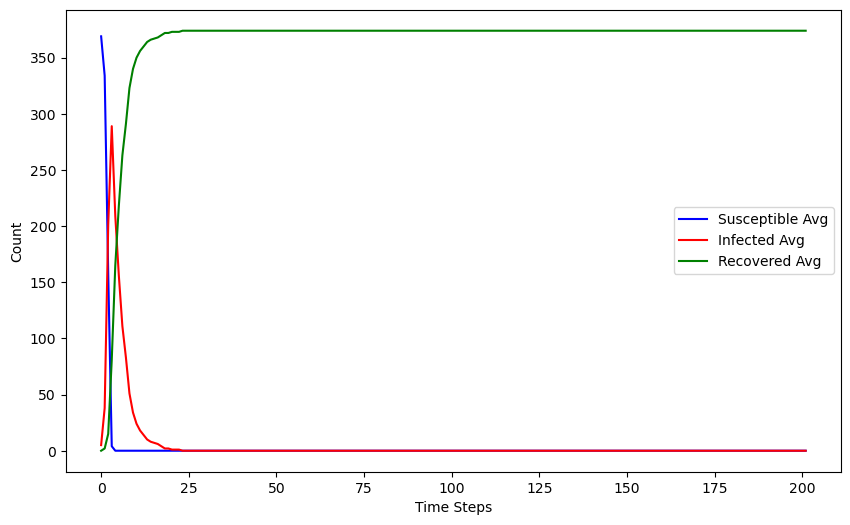

In [14]:
x = np.linspace(0, nr_iterations+1, nr_iterations)

# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(x, S, label="Susceptible Avg", color='blue')
plt.plot(x, I, label="Infected Avg", color='red')
plt.plot(x, R, label="Recovered Avg", color='green')
# plt.title(fr"Average SIR Dynamics over Different values of $\gamma$ with $\beta = {betas[beta_index]}$")
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.show()


## Watts-Stograz network

In [15]:
nodes = np.arange(50, 550, 50) 
k_values = np.arange(1,10,1)
p_values = np.linspace(0.1, 1, 10)

results_WS = []

for size in nodes:
    for k in k_values:
        for p in p_values:
            Graph_WS = nx.watts_strogatz_graph(size, k, p)
            stats_WR = statistic_func(Graph_WS)
            results_WS.append(stats_WR)
            
df_WS = pd.DataFrame(results_WS)

c:\Users\kevin\anaconda3\envs\ABM\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\kevin\anaconda3\envs\ABM\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [16]:
custom_summary = df_WS.groupby(df_WS.columns[0]).agg(['mean', 'std', 'median', 'min', 'max','var'])
display(custom_summary)

Nr_of_edges                                                \
                   mean         std  median  min   max            var   
Nr_of_nodes                                                             
0                   0.0    0.000000     0.0    0     0       0.000000   
50                125.0   56.254395   125.0   50   200    3164.556962   
100               250.0  112.508790   250.0  100   400   12658.227848   
150               375.0  168.763185   375.0  150   600   28481.012658   
200               500.0  225.017580   500.0  200   800   50632.911392   
250               625.0  281.271975   625.0  250  1000   79113.924051   
300               750.0  337.526370   750.0  300  1200  113924.050633   
350               875.0  393.780765   875.0  350  1400  155063.291139   
400              1000.0  450.035160  1000.0  400  1600  202531.645570   
450              1125.0  506.289555  1125.0  450  1800  256329.113924   
500              1250.0  562.543950  1250.0  500  2000  316455.696203   

            Average_degree                            ... diameter       \
                      mean       std  median     min  ...   median  min   
Nr_of_nodes                                           ...                 
0                      NaN       NaN     NaN     NaN  ...      NaN  NaN   
50                   14.75  1.125088   14.75   13.25  ...      5.0  3.0   
100                  27.25  1.125088   27.25   25.75  ...      5.0  4.0   
150                  39.75  1.125088   39.75   38.25  ...      6.0  4.0   
200                  52.25  1.125088   52.25   50.75  ...      7.0  4.0   
250                  64.75  1.125088   64.75   63.25  ...      6.0  4.0   
300                  77.25  1.125088   77.25   75.75  ...      7.0  5.0   
350                  89.75  1.125088   89.75   88.25  ...      6.5  5.0   
400                 102.25  1.125088  102.25  100.75  ...      7.0  5.0   
450                 114.75  1.125088  114.75  113.25  ...      7.0  5.0   
500                 127.25  1.125088  127.25  125.75  ...      7.0  5.0   

                               average_shortest_path_length            \
               max         var                         mean       std   
Nr_of_nodes                                                             
0              NaN         NaN                          NaN       NaN   
50            28.0   40.367199                     3.501057  2.224108   
100           57.0   87.342788                     3.900320  3.119136   
150           89.0  240.947284                     5.440584  5.268903   
200           65.0  253.301408                     5.955860  5.679977   
250           68.0  266.391304                     6.003300  6.043502   
300           86.0  284.474759                     5.960492  5.916726   
350           90.0  294.808532                     5.479947  5.806122   
400          111.0  376.154762                     5.761018  6.607052   
450           67.0  296.767074                     6.381062  6.480487   
500           95.0  249.507937                     5.780803  6.033718   

                                                       
               median       min        max        var  
Nr_of_nodes                                            
0                 NaN       NaN        NaN        NaN  
50           2.609796  2.036735  10.923265   4.946655  
100          2.928889  2.406869  20.002828   9.729011  
150          3.475078  2.605101  31.234631  27.761341  
200          3.786231  2.751508  25.258995  32.262135  
250          3.721446  2.864771  27.769671  36.523911  
300          3.888149  2.960178  31.165931  35.007652  
350          3.791740  3.036856  30.827262  33.711051  
400          3.889987  3.112945  37.385564  43.653142  
450          4.073902  3.170522  27.601802  41.996706  
500          4.062204  3.225002  35.238886  36.405754  

[11 rows x 54 columns]

In [17]:
display(df_WS)

,Nr_of_nodes,Nr_of_edges,Average_degree,average_clustering_coefficient,density,average_degree_centrality,average_betweenness_centrality,average_closeness_centrality,diameter,average_shortest_path_length
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
895,500,2000,128.75,0.052856,0.016032,0.016032,0.004564,0.306002,5.0,3.273082
896,500,2000,128.75,0.030627,0.016032,0.016032,0.004515,0.308325,5.0,3.248529
897,500,2000,128.75,0.018427,0.016032,0.016032,0.004487,0.309662,5.0,3.234333
898,500,2000,128.75,0.015741,0.016032,0.016032,0.004479,0.310082,5.0,3.230717


In [18]:
# Generate Barabasi-Albert graph similar to the given model
Graph_WS = nx.watts_strogatz_graph(374, 4, 0.9)

# Generate SIR model object
SIR_model = ep.SIRModel(Graph_WS)

# Set parameter values
beta = 1.5
gamma = 0.3
percentage_infected = 5/374
nr_iterations = 100

# Pre-allocate variables.
S_store = np.zeros((nr_iterations))
I_store = np.zeros((nr_iterations))
R_store = np.zeros((nr_iterations))

# Run experiment
cfg = mc.Configuration()
cfg.add_model_parameter("percentage_infected", percentage_infected)


# Set every node as susceptible
for node in Graph_obj.nodes():
    SIR_model.status[node] = 0
    
# Set model configurations
cfg.add_model_parameter('beta', beta)
cfg.add_model_parameter('gamma', gamma)
SIR_model.set_initial_status(cfg)
iterations = SIR_model.iteration_bunch(nr_iterations, node_status=True)
trends = SIR_model.build_trends(iterations)

# Extract values based on updated structure
node_counts = trends[0]['trends']['node_count']
S = node_counts[0]
I = node_counts[1]
R = node_counts[2]

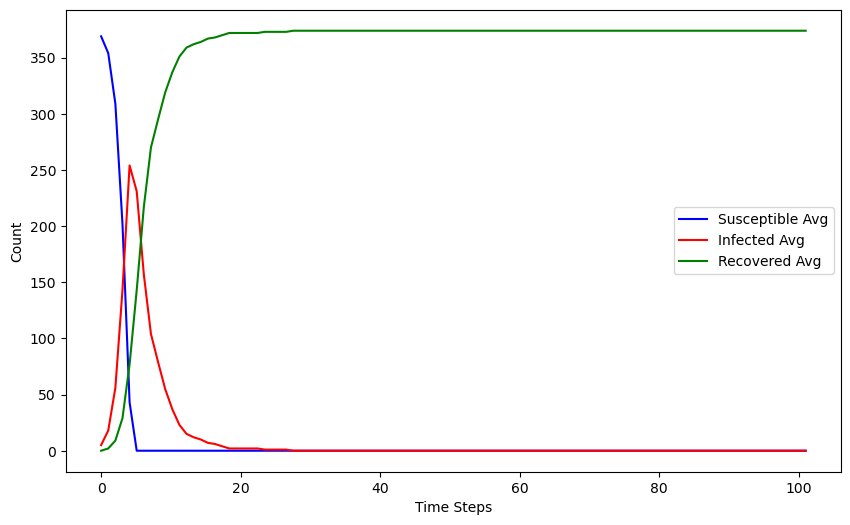

In [19]:
x = np.linspace(0, nr_iterations+1, nr_iterations)

# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(x, S, label="Susceptible Avg", color='blue')
plt.plot(x, I, label="Infected Avg", color='red')
plt.plot(x, R, label="Recovered Avg", color='green')
# plt.title(fr"Average SIR Dynamics over Different values of $\gamma$ with $\beta = {betas[beta_index]}$")
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.show()


## Barabási-Albert network

In [20]:
nodes = np.arange(50,550,50)
m_values = np.arange(1,11,10)

results_BA = []

for size in nodes:
    for m in m_values:
        Graph_BA = nx.barabasi_albert_graph(size, m)
        stats_BA = statistic_func(Graph_BA)
        results_BA.append(stats_BA)
        
df_BA = pd.DataFrame(results_BA)

In [21]:
custom_summary = df_BA.groupby(df_WS.columns[0]).agg(['mean', 'std', 'median', 'min', 'max','var'])
display(custom_summary)

Nr_of_edges                          Average_degree      \
                   mean std median  min  max var           mean std   
Nr_of_nodes                                                           
50                 49.0 NaN   49.0   49   49 NaN      13.230000 NaN   
100                99.0 NaN   99.0   99   99 NaN      25.740000 NaN   
150               149.0 NaN  149.0  149  149 NaN      38.243333 NaN   
200               199.0 NaN  199.0  199  199 NaN      50.745000 NaN   
250               249.0 NaN  249.0  249  249 NaN      63.246000 NaN   
300               299.0 NaN  299.0  299  299 NaN      75.746667 NaN   
350               349.0 NaN  349.0  349  349 NaN      88.247143 NaN   
400               399.0 NaN  399.0  399  399 NaN     100.747500 NaN   
450               449.0 NaN  449.0  449  449 NaN     113.247778 NaN   
500               499.0 NaN  499.0  499  499 NaN     125.748000 NaN   

                                     ... diameter              \
                 median         min  ...   median min max var   
Nr_of_nodes                          ...                        
50            13.230000   13.230000  ...      8.0   8   8 NaN   
100           25.740000   25.740000  ...     12.0  12  12 NaN   
150           38.243333   38.243333  ...     12.0  12  12 NaN   
200           50.745000   50.745000  ...     11.0  11  11 NaN   
250           63.246000   63.246000  ...     12.0  12  12 NaN   
300           75.746667   75.746667  ...     12.0  12  12 NaN   
350           88.247143   88.247143  ...     13.0  13  13 NaN   
400          100.747500  100.747500  ...     15.0  15  15 NaN   
450          113.247778  113.247778  ...     16.0  16  16 NaN   
500          125.748000  125.748000  ...     15.0  15  15 NaN   

            average_shortest_path_length                                        
                                    mean std    median       min       max var  
Nr_of_nodes                                                                     
50                              3.711837 NaN  3.711837  3.711837  3.711837 NaN  
100                             4.080202 NaN  4.080202  4.080202  4.080202 NaN  
150                             5.632304 NaN  5.632304  5.632304  5.632304 NaN  
200                             5.176281 NaN  5.176281  5.176281  5.176281 NaN  
250                             5.177253 NaN  5.177253  5.177253  5.177253 NaN  
300                             5.461962 NaN  5.461962  5.461962  5.461962 NaN  
350                             6.051543 NaN  6.051543  6.051543  6.051543 NaN  
400                             5.888647 NaN  5.888647  5.888647  5.888647 NaN  
450                             7.219015 NaN  7.219015  7.219015  7.219015 NaN  
500                             6.703591 NaN  6.703591  6.703591  6.703591 NaN  

[10 rows x 54 columns]

## Barabási-Albert SIR spread

In [22]:
# Generate Barabasi-Albert graph similar to the given model
Graph_BA = nx.barabasi_albert_graph(374, 4)

# Generate SIR model object
SIR_model = ep.SIRModel(Graph_BA)

# Set parameter values
beta = 1.5
gamma = 0.3
percentage_infected = 5/374
nr_iterations = 200

# Pre-allocate variables.
S_store = np.zeros((nr_iterations))
I_store = np.zeros((nr_iterations))
R_store = np.zeros((nr_iterations))

# Run experiment
cfg = mc.Configuration()
cfg.add_model_parameter("percentage_infected", percentage_infected)


# Set every node as susceptible
for node in Graph_obj.nodes():
    SIR_model.status[node] = 0
    
# Set model configurations
cfg.add_model_parameter('beta', beta)
cfg.add_model_parameter('gamma', gamma)
SIR_model.set_initial_status(cfg)
iterations = SIR_model.iteration_bunch(nr_iterations, node_status=True)
trends = SIR_model.build_trends(iterations)

# Extract values based on updated structure
node_counts = trends[0]['trends']['node_count']
S = node_counts[0]
I = node_counts[1]
R = node_counts[2]

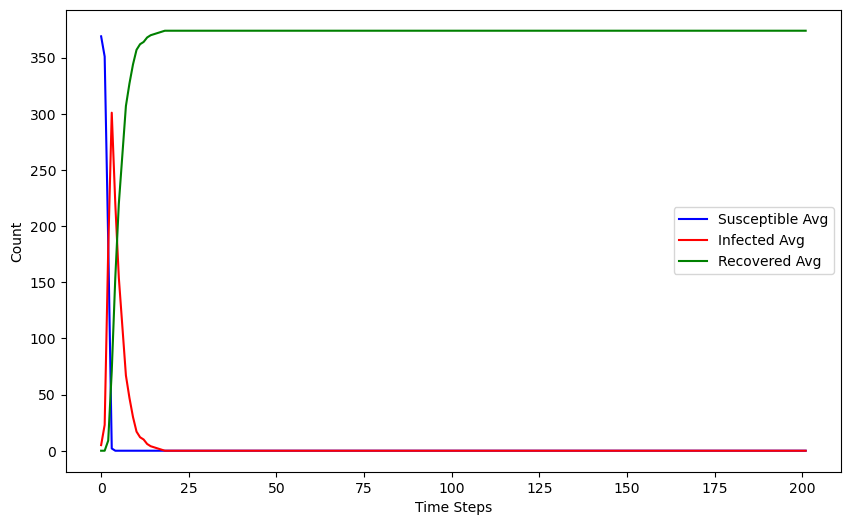

In [23]:
x = np.linspace(0, nr_iterations+1, nr_iterations)

# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(x, S, label="Susceptible Avg", color='blue')
plt.plot(x, I, label="Infected Avg", color='red')
plt.plot(x, R, label="Recovered Avg", color='green')
# plt.title(fr"Average SIR Dynamics over Different values of $\gamma$ with $\beta = {betas[beta_index]}$")
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.show()


## Dynamic Vaccination Campaign

### The null strategy

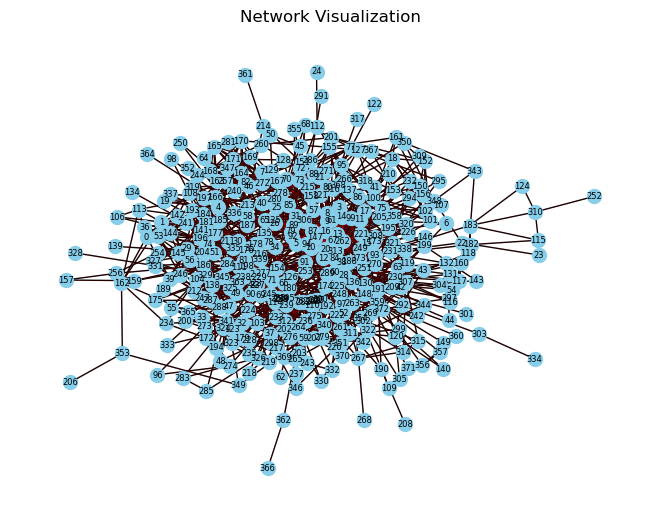

In [176]:
# Import the csv file
df = pd.read_csv('transmission_network.csv', sep=';')
df = df.rename(columns={df.columns[0]:'nodes'})

# Create graph object and add nodes to it
Graph_obj = nx.Graph()
nodes = df['nodes'].tolist()
Graph_obj.add_nodes_from(nodes)

# Add edges between nodes based on the csv-file
for _, row in df.iterrows():
    source_node = row['nodes']
    for col_name, edge_value in row.items():
        if col_name != 'nodes' and edge_value != 0:
            Graph_obj.add_edge(source_node, int(col_name))
            

# Relabel the nodes
Graph_obj = nx.convert_node_labels_to_integers(Graph_obj, first_label=0)

# create a layout for the nodes
pos = nx.kamada_kawai_layout(Graph_obj)

# draw the nodes and edges
nx.draw(Graph_obj, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=6, font_color='black')
nx.draw_networkx_edges(Graph_obj, pos, edge_color='red', width=0.1)

# display the graph
plt.axis('off')
plt.title("Network Visualization")
plt.show()

In [216]:
def simulation_run(S, I, R, vacc_ix, acc_ix, run, null_strategy, SIR_model, non_vaccinated_nodes, vaccinations_per_timestep, test_accuracy, tests_left, vaccinated_nodes):
    for t in range(nr_iterations):
        iteration = SIR_model.iteration(node_status=True)
        if not null_strategy:
            # Pre-allocate useful variables
            counter = 0
            nodes_to_vaccinate = []
            
            # Re-order the list of non_vaccinated_nodes such that the nodes with the highest degrees are vaccinated first.
            node_degrees = {node: Graph_obj.degree(node) for node in non_vaccinated_nodes}
            ranked_nodes = sorted(node_degrees, key=node_degrees.get, reverse=True)
            
            # a list of nodes_to_vaccinate will be appended with nodes that have been tested as susceptible only if there are tests left.
            # So the number of executed tests is dynamic such that the number of detected susceptibles is equal to the number of vaccinations 
            # that is allowed to perform each timestep or the number of tests we can execute is 0. 
            while len(nodes_to_vaccinate) < vaccinations_per_timestep and tests_left > 0:
                p = np.random.uniform()
                
                # We don't vaccinate false negatives (so the node is actually susceptible, but is tested as something else).
                # We do add false positives (so the node is falsely tested to be susceptible) to the vaccination lists, but don't change the state.
                # If it was already recovered, it won't change. 
                # If it was infected, the vaccination won't make the node go to recovered quicker than the infected state will. 
                if p < test_accuracy and SIR_model.status[ranked_nodes[counter]] == 0:
                    nodes_to_vaccinate.append(ranked_nodes[counter])
                elif p > test_accuracy and (SIR_model.status[ranked_nodes[counter]] == 1 or SIR_model.status[ranked_nodes[counter]] == 2):
                    nodes_to_vaccinate.append(ranked_nodes[counter])
                counter += 1
                tests_left -= 1
            
            # How to deal with having no tests left
            if len(nodes_to_vaccinate) < vaccinations_per_timestep:
                diff = vaccinations_per_timestep - len(nodes_to_vaccinate)
                for i in range(diff):
                    if counter + i < len(ranked_nodes):
                        nodes_to_vaccinate.append(ranked_nodes[counter+i])

        else: 
            nodes_to_vaccinate = np.random.choice(list(non_vaccinated_nodes), min(vaccinations_per_timestep, len(non_vaccinated_nodes)), replace=False)
            

        for node in nodes_to_vaccinate:
            if SIR_model.status[node] == 1:
                vaccinated_nodes.add(node)
                non_vaccinated_nodes.remove(node)
            else: 
                SIR_model.status[node] = 2 
                vaccinated_nodes.add(node)
                non_vaccinated_nodes.remove(node)

        # Extract values based on updated structure
        node_counts = SIR_model.build_trends([iteration])[0]['trends']['node_count']
        S[acc_ix, vacc_ix, null_strategy, run, t] = node_counts[0][-1]
        I[acc_ix, vacc_ix, null_strategy, run, t] = node_counts[1][-1]
        R[acc_ix, vacc_ix, null_strategy, run, t] = node_counts[2][-1]
        
    return S, I, R

In [218]:
test_accuracies = [0.5, 0.75, 1]
vaccinations_per_timestep_Values = [1, 3, 5, 10]
null_strategies = [0, 1]
runs = 100

# Pre-allocate variables.
S = np.zeros((len(test_accuracies), len(vaccinations_per_timestep_Values), len(null_strategies), runs, nr_iterations))
I = np.zeros((len(test_accuracies), len(vaccinations_per_timestep_Values), len(null_strategies), runs, nr_iterations))
R = np.zeros((len(test_accuracies), len(vaccinations_per_timestep_Values), len(null_strategies), runs, nr_iterations))
x = np.linspace(0, nr_iterations+1, nr_iterations)


for vacc_ix, vaccinations_per_timestep in enumerate(vaccinations_per_timestep_Values):
    for acc_ix, test_accuracy in enumerate(test_accuracies):
        for null_strategy in null_strategies:
            for run in range(runs):
                # Generate SIR model object
                SIR_model = ep.SIRModel(Graph_obj)

                # Set parameter values
                beta = 1.5
                gamma = 0.3
                percentage_infected = 5/374
                nr_iterations = 50
                tests_left = 200


                vaccinated_nodes = set()
                non_vaccinated_nodes = set(Graph_obj.nodes())

                # Run experiment
                cfg = mc.Configuration()
                cfg.add_model_parameter("percentage_infected", percentage_infected) 


                # (Re)set every node as susceptible
                for node in Graph_obj.nodes():
                    SIR_model.status[node] = 0
                    
                # Set model configurations
                cfg.add_model_parameter('beta', beta)
                cfg.add_model_parameter('gamma', gamma)
                SIR_model.set_initial_status(cfg)

                S, I, R = simulation_run(S, I, R, vacc_ix, acc_ix, run, null_strategy, SIR_model, non_vaccinated_nodes, vaccinations_per_timestep, test_accuracy, tests_left, vaccinated_nodes)



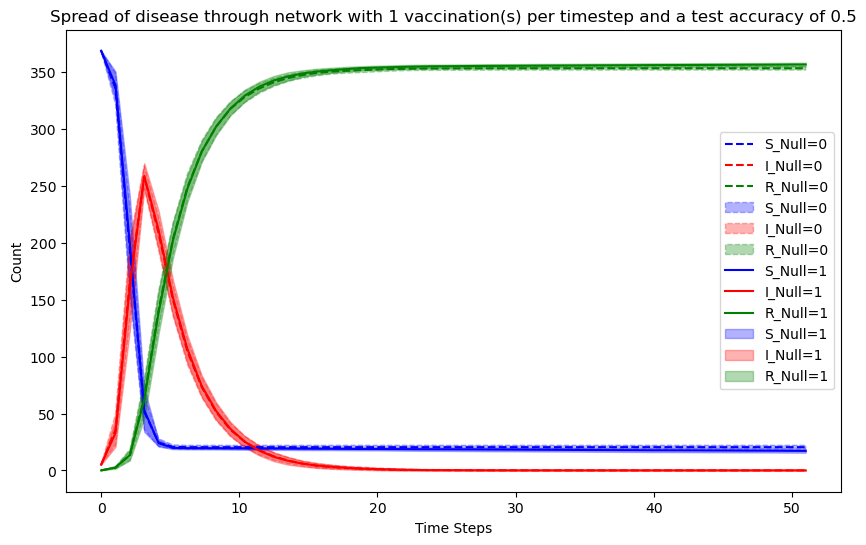

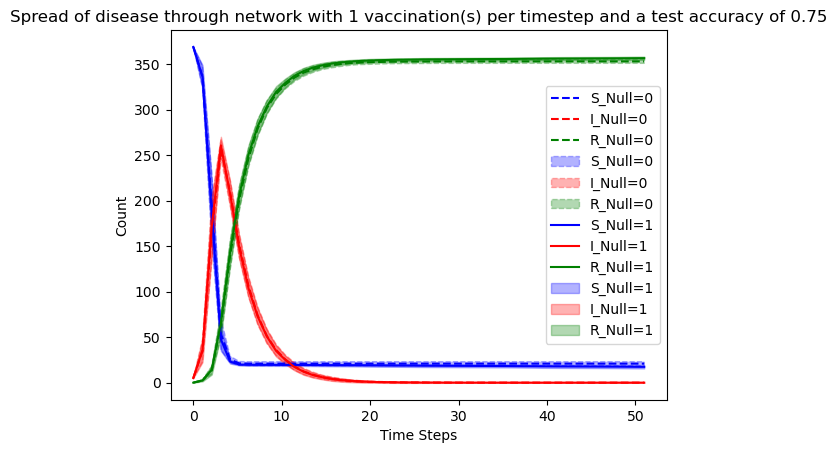

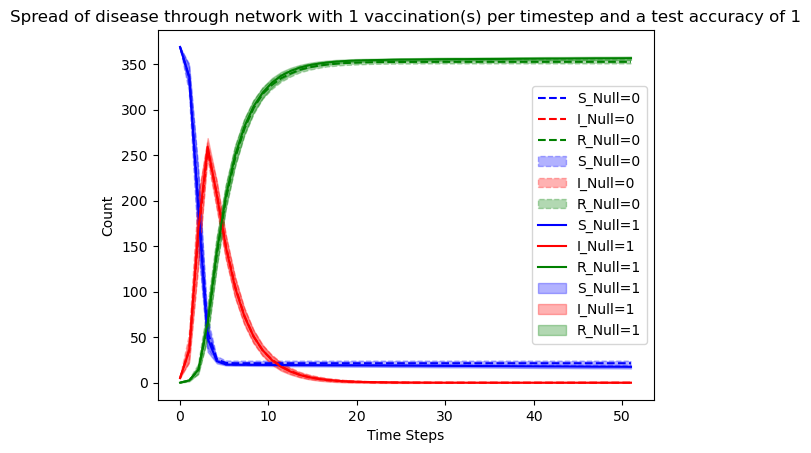

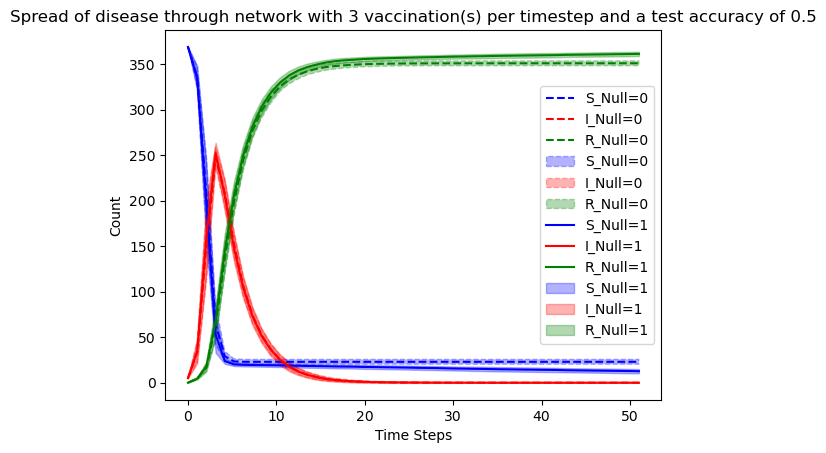

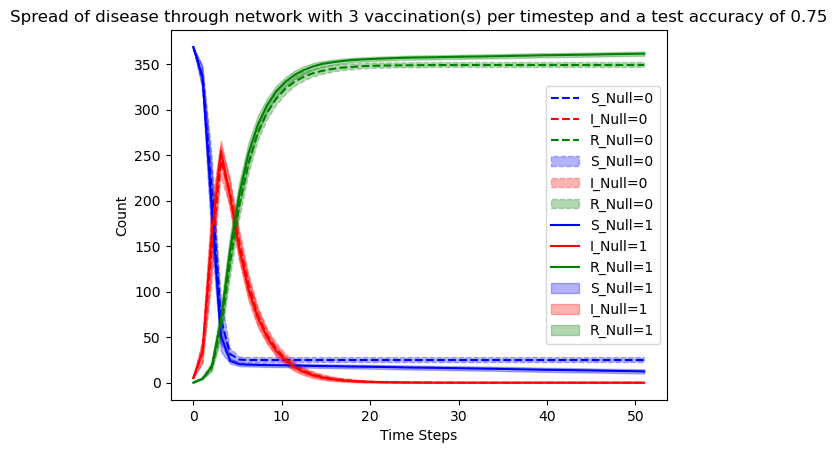

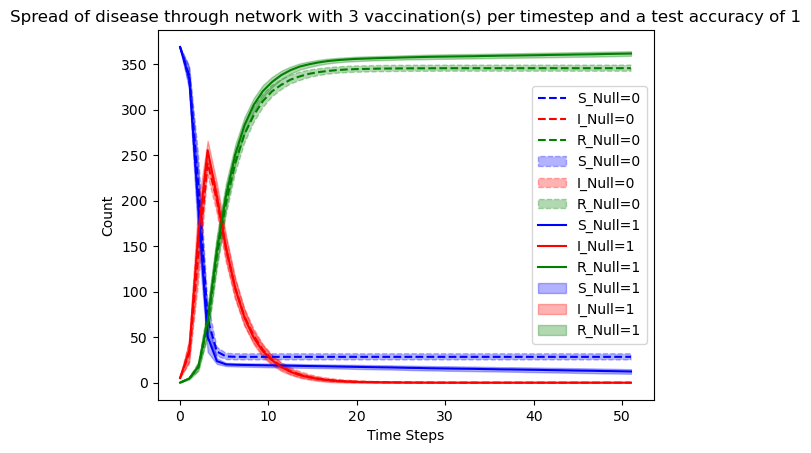

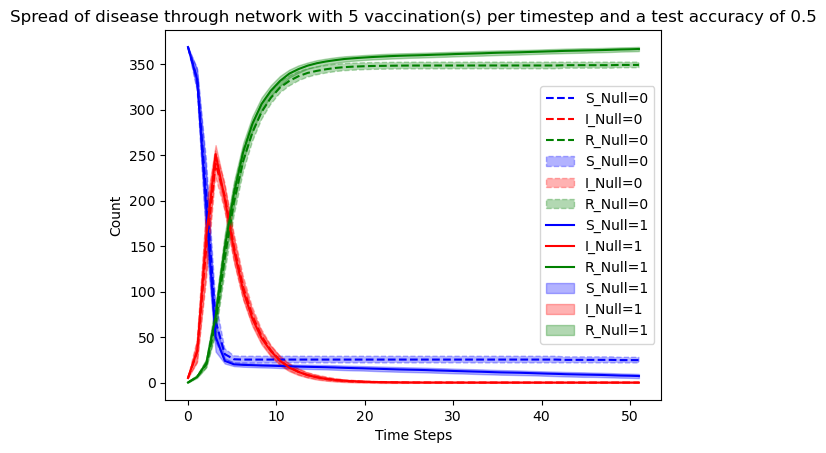

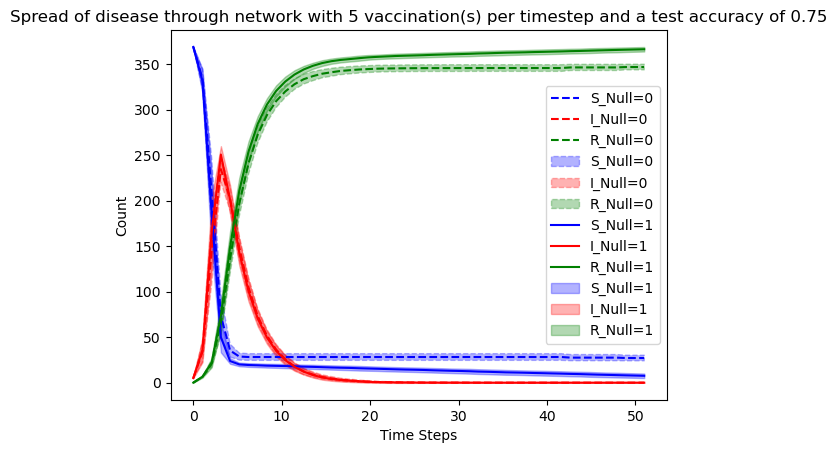

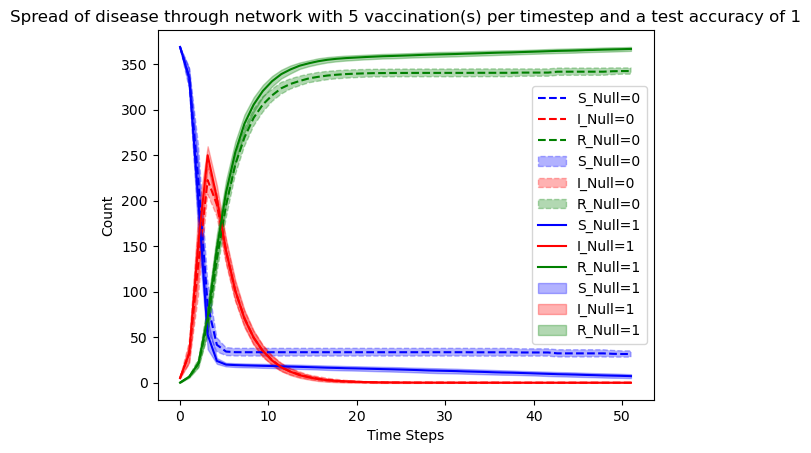

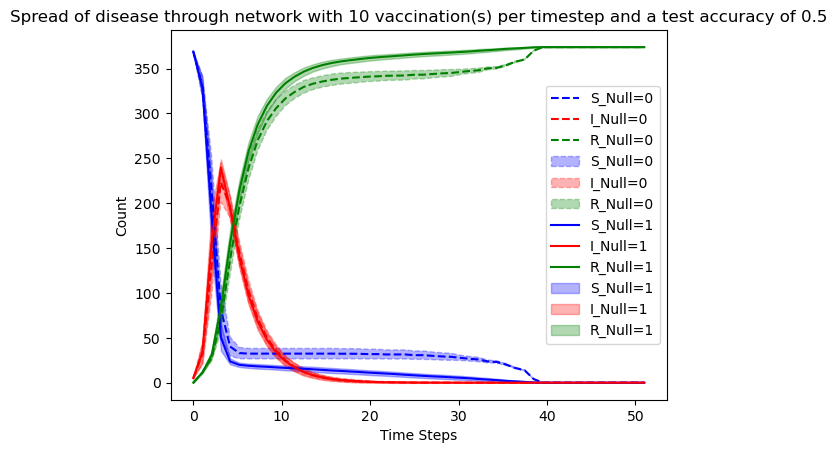

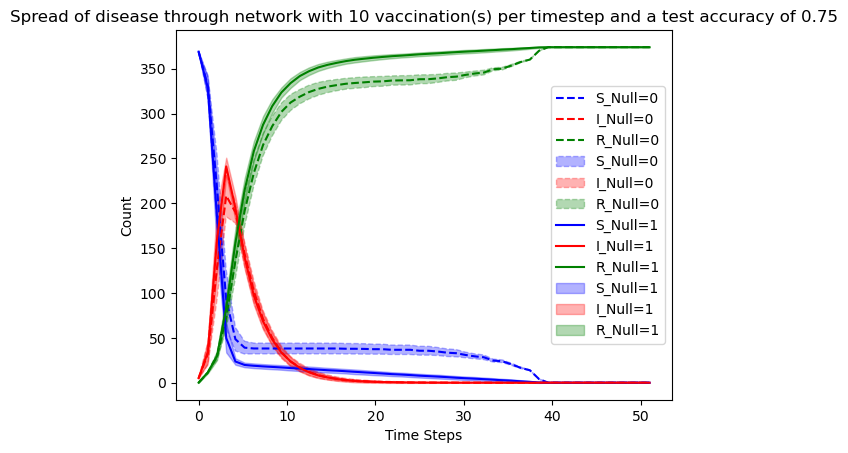

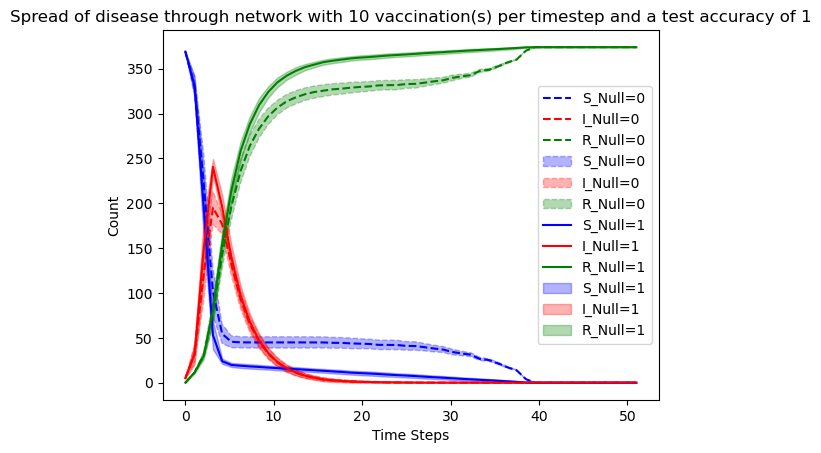

In [231]:
S_mean = np.mean(S, axis=3)
I_mean = np.mean(I, axis=3)
R_mean = np.mean(R, axis=3)
S_std = np.std(S, axis=3)
I_std = np.std(I, axis=3)
R_std = np.std(R, axis=3)

plt.figure(figsize=(10, 6))
for vacc_ix, vaccinations_per_timestep in enumerate(vaccinations_per_timestep_Values):
    for acc_ix, test_accuracy in enumerate(test_accuracies):
        for null_strategy in null_strategies:
            # Plot of average dynamics
            if null_strategy:
                linestyle='-'
            else:
                linestyle='--'
            plt.plot(x, S_mean[acc_ix, vacc_ix, null_strategy], label=f"S_Null={null_strategy}", color='blue', linestyle=linestyle)
            plt.plot(x, I_mean[acc_ix, vacc_ix, null_strategy], label=f"I_Null={null_strategy}", color='red', linestyle=linestyle)
            plt.plot(x, R_mean[acc_ix, vacc_ix, null_strategy], label=f"R_Null={null_strategy}", color='green', linestyle=linestyle)
            plt.fill_between(x, S_mean[acc_ix, vacc_ix, null_strategy]+S_std[acc_ix, vacc_ix, null_strategy], S_mean[acc_ix, vacc_ix, null_strategy]-S_std[acc_ix, vacc_ix, null_strategy], label=f"S_Null={null_strategy}", color='blue', linestyle=linestyle, alpha=0.3)
            plt.fill_between(x, I_mean[acc_ix, vacc_ix, null_strategy]+I_std[acc_ix, vacc_ix, null_strategy], I_mean[acc_ix, vacc_ix, null_strategy]-I_std[acc_ix, vacc_ix, null_strategy], label=f"I_Null={null_strategy}", color='red', linestyle=linestyle, alpha=0.3)
            plt.fill_between(x, R_mean[acc_ix, vacc_ix, null_strategy]+R_std[acc_ix, vacc_ix, null_strategy], R_mean[acc_ix, vacc_ix, null_strategy]-R_std[acc_ix, vacc_ix, null_strategy], label=f"R_Null={null_strategy}", color='green', linestyle=linestyle, alpha=0.3)
        plt.title(f'Spread of disease through network with {vaccinations_per_timestep}'
                f' vaccination(s) per timestep and a test accuracy of {test_accuracy}')
        plt.xlabel("Time Steps")
        plt.ylabel("Count")
        plt.legend()
        plt.show()